# CP2: Using FFT to solve PDEs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

In [13]:
def RK4(F, x0, t0, T, K):
    """
    Return numerical solution of ODE x'=F(x) and time grid.

    INPUT
        F: slope function
        x0: initial condition
        t0: initial time
        T: final time
        K: number of time steps
    OUTPUT
        sol, tgrid: numerical solution and time grid
    """
    dd = x0.size
    tgrid = np.linspace(t0, T, K+1)
    xx = np.zeros((K+1, dd))
    xx[0] = x0

    for k in range(K):
        # time step
        tau = tgrid[k+1] - tgrid[k]
        x = xx[k]
        t = tgrid[k]

        # Runge-Kutta 4th order
        k1 = F(t, x)
        k2 = F(t, x + tau/2*k1)
        k3 = F(t, x + tau/2*k2)
        k4 = F(t, x + tau*k3)
        xx[k+1] = x + tau/6*(k1 + 2*k2 + 2*k3 + k4)
    
    return xx, tgrid

## Solving the Heat Equation
### Using FFT
#### First Example: Box wave initial condition

In [20]:
a = 1 # thermal diffusivity coefficient
L = 100 # length of the domain
N = 1000 # number of spatial points
dx = L / N
x = np.arange(-L/2, L/2, dx) # create points in an x axis

# Create signal numbers
omega = 2. * np.pi * np.fft.fftfreq(N, d  = dx)

# Initial condition box wave with height intial height of 1
u0 = np.zeros_like(x)
u0[int((L/2 - L/10)/dx):int((L/2 + L/10)/dx)] = 1

# Perform FFT on initial wave
u0hat = np.fft.fft(u0)

# using scipy odeint for now, change to other ode solver method
u0hat_split = np.concatenate((u0hat.real, u0hat.imag))

In [21]:
# Frequencies for time domain
dt = 0.1
t = np.arange(0, 10, dt)

# solve equation using fft with real and imaginary parts
def rhsHeat(uhat_split, t, omega, a):
    uhat = uhat_split[:N] + (1j) * uhat_split[N:]
    d_uhat = -a**2 * (np.power(omega, 2)) * uhat
    d_uhat_split = np.concatenate((d_uhat.real, d_uhat.imag)).astype('float64')
    return d_uhat_split

# use scipy's ode solver to compute solution of fft transformation
uhat_split = odeint(rhsHeat, u0hat_split, t, args = (omega, a))

uhat = uhat_split[:, :N] + (1j) * uhat_split[:, N:]

u = np.zeros_like(uhat)

for i in range(len(t)):
    u[i, :] = np.fft.ifft(uhat[i, :])

u = u.real

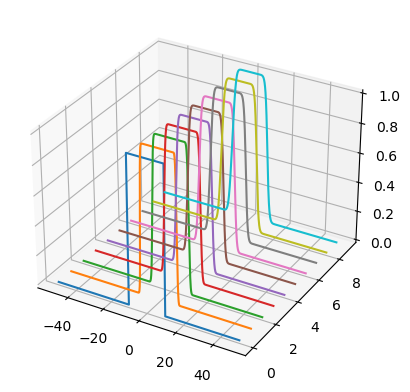

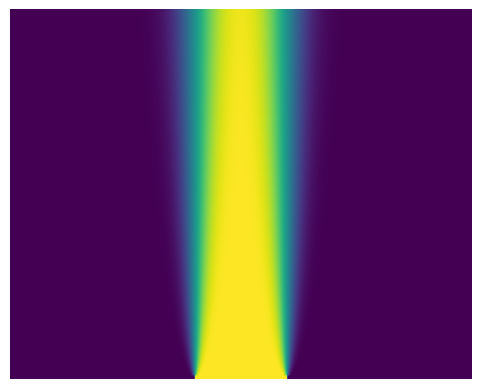

In [22]:
# plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
u_plot = u[0:-1:10,:]
for i in range(u_plot.shape[0]):
    y = i * np.ones(u.shape[1])
    ax.plot(x, y, u[i,:])

plt.figure()
plt.imshow(np.flipud(u), aspect = 8)
plt.axis('off')
plt.show()

### Transport Equation

In [19]:
c = 2 # wave speed
L = 20 # length of domain
N = 1000 # number of spatial points
dx = L / N
x = np.arange(- L/2, L/2, dx) # domain of x points

omega = 2. * np.pi * np.fft.fftfreq(N, d = dx)

# initial condition
u0 = 1. / np.cosh(x)
u0hat = np.fft.fft(u0)

# split into real and imaginary parts for scipy's odeint
u0hat_split = np.concatenate((u0hat.real, u0hat.imag))

# time frequency domain
dt = 0.025
t = np.arange(0, 100*dt, dt)

def rhsWave(uhat_split, t, omega, c):
    uhat = uhat_split[:N] + (1j) * uhat_split[N:]
    d_uhat = -c * (1j) * omega * uhat
    d_uhat_split = np.concatenate((d_uhat.real, d_uhat.imag)).astype('float64')
    return d_uhat_split

uhat_split = odeint(rhsWave, u0hat_split, t, args = (omega, c))
uhat = uhat_split[:, :N] + (1j) * uhat_split[:, N:]

u = np.zeros_like(uhat)

for i in range(len(t)):
    u[i, :] = np.fft.ifft(uhat[i, :])

u = u.real

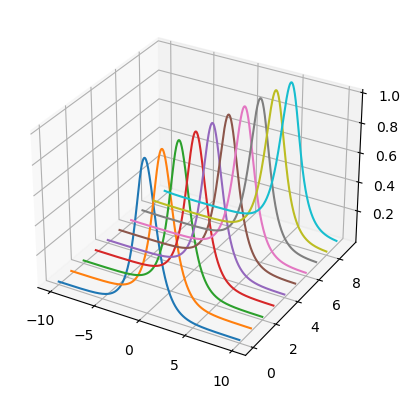

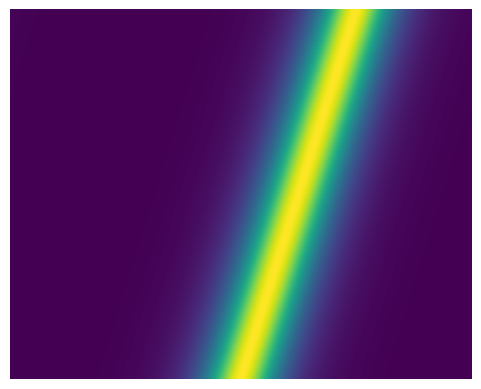

In [20]:
# plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
u_plot = u[0:-1:10,:]
for i in range(u_plot.shape[0]):
    y = i * np.ones(u_plot.shape[1])
    ax.plot(x, y, u_plot[i,:])

plt.figure()
plt.imshow(np.flipud(u), aspect = 8)
plt.axis('off')
plt.show()